In [71]:
import numpy as np
import pandas as pd
import datetime as dt
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
%config InlineBackend.figure_formats = ['svg']  # or retina

%matplotlib inline
sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)


/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
tik_tok_df = pd.read_csv('tiktok_app_reviews.csv')

/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
tik_tok_df =tik_tok_df.drop(columns='review_id')

In [4]:
tik_tok_df.head()

,review_text,upvotes,app_version,posted_date
0,It is an excellent solution to finding videos ...,402,21.2.5,2021-09-20 07:50:23
1,Great app works really well so many features s...,67,21.2.5,2021-09-19 23:10:47
2,I down loaded app but didnt work . i love this...,24,21.2.5,2021-09-19 08:59:34
3,IT A GREAT APP AND FUN TO USE! HOWEVER ARBITRA...,18,21.2.5,2021-09-19 16:34:43
4,Currently it's working good for me except a fe...,232,21.1.41,2021-09-14 06:35:02


In [5]:
tik_tok_df['date'] = pd.to_datetime(tik_tok_df['posted_date'], infer_datetime_format= True).dt.date

In [6]:
split_date= dt.date(2020,1,1)

In [7]:
tik_tok_20_21 = tik_tok_df.loc[tik_tok_df['date']>split_date]

In [8]:
tik_tok_20_21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1937876 entries, 0 to 3646475
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_text  object
 1   upvotes      int64 
 2   app_version  object
 3   posted_date  object
 4   date         object
dtypes: int64(1), object(4)
memory usage: 88.7+ MB


In [9]:
tik_tok_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646476 entries, 0 to 3646475
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_text  object
 1   upvotes      int64 
 2   app_version  object
 3   posted_date  object
 4   date         object
dtypes: int64(1), object(4)
memory usage: 139.1+ MB


In [10]:
tik_tok_20_21.review_text.isnull().sum()

16

Only 16 null reviews out of 1.9 million, so can probably drop them without too much impact

In [11]:
tik_tok_20_21.loc[tik_tok_20_21.review_text.isnull()]

,review_text,upvotes,app_version,posted_date,date
1713596,NaN,0,19.5.43,2021-06-16 11:39:27,2021-06-16
1724879,NaN,0,19.5.4,2021-05-19 03:56:05,2021-05-19
1729379,NaN,0,19.3.4,2021-05-25 23:51:17,2021-05-25
1762648,NaN,0,18.8.41,2021-04-09 05:12:47,2021-04-09
1782371,NaN,0,18.6.6,2021-03-04 19:01:34,2021-03-04
1824753,NaN,0,18.3.6,2021-01-31 07:27:14,2021-01-31
2079417,NaN,0,15.9.6,2020-05-11 14:45:00,2020-05-11
2117121,NaN,0,15.7.5,2020-04-20 08:48:29,2020-04-20
2144000,NaN,0,15.5.42,2020-05-04 01:45:30,2020-05-04
2212880,NaN,0,15.2.4,2020-03-15 04:03:22,2020-03-15


In [12]:
no_null_reviews_df = tik_tok_20_21.dropna(subset=['review_text'])

In [13]:
no_null_reviews_df.review_text.isnull().sum()

0

In [14]:
no_null_reviews_df['spacy_cleaned'] = list(nlp.pipe(no_null_reviews_df.review_text))

/var/folders/ct/v_q82qz551vg3s2wptrzz4cw0000gp/T/ipykernel_22298/2548810918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_null_reviews_df['spacy_cleaned'] = list(nlp.pipe(no_null_reviews_df.review_text))


In [15]:
no_null_reviews_df.review_text.isnull().sum()

0

In [16]:
no_null_reviews_df.spacy_cleaned.sample(2)

614113     (I, love, tiktok, its, a, way, of, time, passing)
1805023                                              (Great)
Name: spacy_cleaned, dtype: object

In [17]:
no_null_reviews_df['spacy_cleaned'].iloc[1841570].lang_

'en'

Looks like the parser worked, emojis are still in there but I believe they can stay since they can sometimes show patterns that are positive. However there's reviews in other languages, which will have their own sentiment and we can see about organizing them at a later date.

In [18]:
docs_clean = [[w.lemma_.lower() for w in doc if (not w.is_stop and not w.is_punct and not w.like_num) \
               or (w.lemma_=='not')] for doc in no_null_reviews_df['spacy_cleaned'] if doc.lang_=='en']
no_null_reviews_df['docs_clean'] = docs_clean

/var/folders/ct/v_q82qz551vg3s2wptrzz4cw0000gp/T/ipykernel_22298/1836662315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_null_reviews_df['docs_clean'] = docs_clean


In [19]:
no_null_reviews_df.head()

,review_text,upvotes,app_version,posted_date,date,spacy_cleaned,docs_clean
0,It is an excellent solution to finding videos ...,402,21.2.5,2021-09-20 07:50:23,2021-09-20,"(It, is, an, excellent, solution, to, finding,...","[excellent, solution, find, video, follow, peo..."
1,Great app works really well so many features s...,67,21.2.5,2021-09-19 23:10:47,2021-09-19,"(Great, app, works, really, well, so, many, fe...","[great, app, work, feature, new, feature, lot,..."
2,I down loaded app but didnt work . i love this...,24,21.2.5,2021-09-19 08:59:34,2021-09-19,"(I, down, loaded, app, but, did, nt, work, ., ...","[load, app, nt, work, love, app, maybe, fix, b..."
3,IT A GREAT APP AND FUN TO USE! HOWEVER ARBITRA...,18,21.2.5,2021-09-19 16:34:43,2021-09-19,"(IT, A, GREAT, APP, AND, FUN, TO, USE, !, HOWE...","[great, app, fun, use, arbitrary, algorithms, ..."
4,Currently it's working good for me except a fe...,232,21.1.41,2021-09-14 06:35:02,2021-09-14,"(Currently, it, 's, working, good, for, me, ex...","[currently, work, good, clip, video, work, hou..."


In [20]:
docs_list_clean = [' '.join(doc) for doc in docs_clean]
docs_list_clean[:4]

['excellent solution find video follow people similar interest excellent solution rediscover environment society give respect environment society public view private view',
 'great app work feature new feature lot popular trend thing app like find friend post video like duet share yes sponsor tik tok scam app pretty content foryou page wo load great app continue improve yes stars',
 'load app nt work love app maybe fix bug easy load well like sign facebook google work good phone tho ipad not work fix',
 'great app fun use arbitrary algorithms blocking banning takedowns etc alleged report reporter able report evidence evidence acquire action evidence require uncorroborated report[s wreck persons rep account -if inclusive environment prove needs far well customer service online phone u know phone app great invent people talk']

In [21]:
stop_words= ENGLISH_STOP_WORDS.union(['tik', 'tok', 'tiktok', 'plz', 'aap', 'ap', 'thing', 'pls', 'tick', 'tock', 'ticktock', 'video', 'app'])

# Topic Modeling

In [136]:
cv = CountVectorizer(stop_words=stop_words, max_df=.5, min_df=10, strip_accents='unicode', max_features=1000)
tfid =TfidfVectorizer(stop_words=stop_words, max_df=.5, min_df=10, strip_accents='unicode', max_features=1000)
# The second document-term matrix has both unigrams and bigrams
cv2 = CountVectorizer(ngram_range=(1,2), stop_words=stop_words, max_df=.5, min_df=10, strip_accents='unicode', max_features=1000)


In [137]:
X1 = cv.fit_transform(docs_list_clean)
X2 = tfid.fit_transform(docs_list_clean)
bi_grams=cv2.fit_transform(docs_list_clean)

In [24]:
print(X1.shape)
print(X2.shape)

(1937860, 1000)
(1937860, 1000)


## LSA

In [101]:
lsa = TruncatedSVD(n_components=20)
lsa.fit(X2)

TruncatedSVD(n_components=20)

In [102]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [103]:
display_topics(lsa, tfid.get_feature_names(), 10)


Topic  0
good, love, nice, like, fun, entertainment, world, time, amazing, application

Topic  1
love, nice, amazing, fun, like, great, awesome, cool, funny, people

Topic  2
nice, like, application, wow, entertainment, super, enjoy, time, work, pass

Topic  3
like, amazing, fun, great, cool, awesome, follower, funny, people, follow

Topic  4
amazing, fun, wow, nice, good, great, experience, download, word, recommend

Topic  5
fun, great, cool, super, watch, funny, awesome, lot, use, time

Topic  6
great, time, entertainment, experience, awesome, way, people, content, work, platform

Topic  7
awesome, super, cool, thank, funny, people, experience, wow, entertainment, time

Topic  8
super, cool, funny, wow, duper, entertainment, excellent, time, star, pass

Topic  9
cool, funny, people, pretty, wow, watch, dance, stuff, friend, soo

Topic  10
excellent, funny, wow, thank, viral, entertainment, account, time, experience, application

Topic  11
funny, wow, watch, people, time, viral, enj

## NMF

In [104]:
nmf = NMF(n_components=20)
nmf.fit_transform(X2)


/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


array([[3.69023579e-05, 7.67042701e-05, 2.88508156e-05, ...,
        3.21254438e-04, 2.48377520e-03, 1.61421020e-03],
       [6.56767863e-05, 1.05224082e-04, 3.47439896e-05, ...,
        4.00058306e-04, 1.99815431e-03, 2.13416197e-03],
       [3.16043874e-03, 3.88890342e-03, 4.79151903e-05, ...,
        1.66633481e-04, 1.11058254e-03, 5.81316438e-04],
       ...,
       [5.98667852e-07, 6.25054162e-07, 1.84459566e-10, ...,
        1.11360635e-05, 1.29259701e-05, 1.48701816e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [105]:
display_topics(nmf, tfid.get_feature_names(), 10)


Topic  0
good, world, experience, application, work, download, use, social, people, job

Topic  1
love, dance, make, people, watch, day, nepal, friend, life, absolutely

Topic  2
nice, application, work, experience, use, appp, apk, verry, beautiful, people

Topic  3
like, follower, follow, view, people, dance, lot, watch, nt, comment

Topic  4
amazing, people, download, experience, recommend, word, use, friend, application, star

Topic  5
fun, watch, lot, use, entertaining, people, dance, friend, make, easy

Topic  6
great, experience, people, way, content, work, use, platform, friend, lot

Topic  7
awesome, experience, people, application, download, word, platform, use, entertaining, friend

Topic  8
super, duper, star, application, entertaining, hit, fantastic, addictive, se, addict

Topic  9
cool, pretty, people, dance, watch, stuff, friend, soo, lot, download

Topic  10
excellent, experience, work, application, performance, service, superb, snack, platform, job

Topic  11
funny, w

## LDA

In [109]:
lda_tf = LatentDirichletAllocation(n_components=6)
lda_tf.fit(X1)

LatentDirichletAllocation(n_components=6)

In [110]:
pyLDAvis.sklearn.prepare(lda_tf, X1, cv)

/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.181166 -0.031411       1        1  21.016548
3      0.186799  0.017066       2        1  20.146433
5      0.134969  0.126243       3        1  17.174188
1     -0.276428 -0.327947       4        1  15.673406
4      0.095281 -0.085520       5        1  13.167113
0     -0.321787  0.301570       6        1  12.822311, topic_info=          Term           Freq          Total Category  logprob  loglift
352       good  365715.000000  365715.000000  Default  30.0000  30.0000
533       love  309974.000000  309974.000000  Default  29.0000  29.0000
608       nice  180816.000000  180816.000000  Default  28.0000  28.0000
507       like  133930.000000  133930.000000  Default  27.0000  27.0000
328        fun  108193.000000  108193.000000  Default  26.0000  26.0000
..         ...            ...            ...      ...      ...      ...
531        lot    3035.467575   18938.942998   Topic6  -5.0378   0.2231
234       easy    1772.318056    8153.903500   Topic6  -5.5759   0.5278
111       bore    1268.288963    3805.205510   Topic6  -5.9105   0.9553
223   download    1718.119791   17190.967884   Topic6  -5.6070  -0.2492
252  entertain    1092.799315    8744.059655   Topic6  -6.0594  -0.0256

[340 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3         1  0.005473          1k
3         2  0.119032          1k
3         4  0.587637          1k
3         5  0.287320          1k
11        2  0.000279  absolutely
...     ...       ...         ...
989       3  0.159766         توك
989       4  0.838324         توك
990       4  0.995928         تيك
991       3  0.999225         جدا
992       3  0.999103        جميل

[641 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 6, 2, 5, 1])

In [112]:
display_topics(lda_tf, cv.get_feature_names(), 10)


Topic  0
nice, fun, cool, super, excellent, entertainment, addict, soo, watch, use

Topic  1
good, amazing, world, live, application, experience, entertainment, social, platform, lovely

Topic  2
great, awesome, account, viral, star, view, team, follow, thank, problem

Topic  3
people, funny, help, want, new, friend, lot, ok, life, watch

Topic  4
love, thank, bad, wonderful, dance, fantastic, best, follower, game, absolutely

Topic  5
like, time, day, enjoy, wow, make, happy, entertaining, use, pass


In [113]:
lda_tf.fit(bi_grams)

/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/alexstake

LatentDirichletAllocation(n_components=6)

In [114]:
pyLDAvis.sklearn.prepare(lda_tf, bi_grams, cv2)

/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.184334 -0.063399       1        1  21.793662
0      0.146196 -0.077979       2        1  18.314956
3      0.090842 -0.202804       3        1  16.093029
5     -0.439720 -0.124294       4        1  16.061761
1      0.066936  0.083255       5        1  15.825831
2     -0.048589  0.385222       6        1  11.910762, topic_info=         Term           Freq          Total Category  logprob  loglift
305      good  347821.000000  347821.000000  Default  30.0000  30.0000
523      love  290380.000000  290380.000000  Default  29.0000  29.0000
643      nice  161122.000000  161122.000000  Default  28.0000  28.0000
483      like  127713.000000  127713.000000  Default  27.0000  27.0000
34    amazing   92796.000000   92796.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
705  platform    5098.613910    8368.478901   Topic6  -4.5182   1.6322
816     spend    4082.354643    5770.184693   Topic6  -4.7405   1.7817
669       omg    3404.440701    4393.194164   Topic6  -4.9221   1.8728
842   support    3946.395715    7158.964834   Topic6  -4.7744   1.5322
903       use    3755.605744   22194.403562   Topic6  -4.8239   0.3511

[332 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4         3  0.000240  absolutely
4         6  0.999599  absolutely
7         1  0.006496     account
7         5  0.993466     account
7         6  0.000023     account
...     ...       ...         ...
984       2  0.004294        year
984       3  0.530575        year
984       5  0.027247        year
984       6  0.000148        year
987       6  0.999793         yes

[595 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 6, 2, 3])

In [115]:
display_topics(lda_tf, cv2.get_feature_names(), 10)


Topic  0
like, awesome, super, funny, people, follow, entertaining, live, enjoy, day

Topic  1
amazing, cool, account, viral, follower, excellent, view, foryou, team, problem

Topic  2
time, wow, star, download, pass, hai, time pass, best, perfect, free

Topic  3
love, great, thank, make, ok, day, good love, easy, love love, addictive

Topic  4
fun, people, want, friend, new, happy, dance, lot, watch, life

Topic  5
good, nice, world, entertainment, nyc, social, lovely, good good, good entertainment, good like


## CorEx

In [138]:
words = list(np.asarray(cv.get_feature_names()))
words2= list(np.asarray(cv2.get_feature_names()))

In [139]:
topic_model = ct.Corex(n_hidden=4, words=words)

In [140]:
topic_model.fit(X1, words=words, docs=no_null_reviews_df.review_text)

In [141]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: time,people,make,watch,fun,friend,day,pass,lot,new
1: account,viral,team,follower,view,like,want,dear,help,live
2: love,nice,good,amazing,great,funny,cool,addict,excellent,addicted
3: work,year,god,man,bad,girl,fine,oh,boy,appreciate


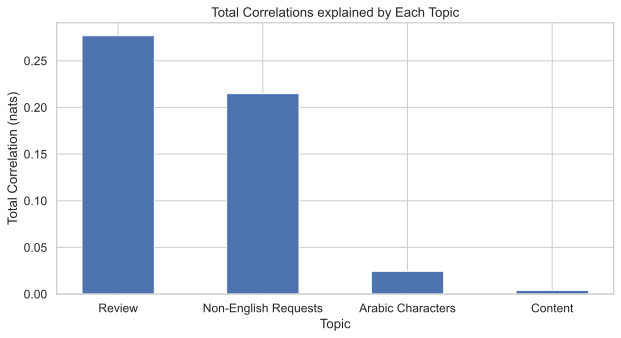

In [142]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, width=0.5);
plt.xlabel('Topic')
plt.ylabel('Total Correlation (nats)')
plt.title('Total Correlations explained by Each Topic')
plt.xticks(np.arange(4), ['Review', 'Non-English Requests', 'Arabic Characters', 'Content'])
plt.savefig('figures/corex_tc_topic.png', bbox_inches = 'tight');
plt.savefig('figures/corex_tc_topic.svg', bbox_inches = 'tight');

In [153]:
topic_model.get_top_docs(topic=2, n_docs=3)

[("I absolutely love Tik Tok! It's informative, hilarious, and I've met some really good folks on here! The videos are great, the people are amazing, everyone is doing different things and there are yummy video recipes too! A little bit of everything! Plus, it helps th o pass t j.g e time during this COVID-19 quarantine LOL! 😁😁😁",
  0.0),
 ("The most amazing app I have ever had. It's just full of things u love to absolutely hilarious videos that will have u gasping for air 😂😂and trust me u will never get bored of this app, I'm technically obsessed with it. Tiktok has got everything u need, I only recommend it for 13+ and over Download it now!🥰🙂",
  0.0),
 ("It's freaking hilarious. Absolutely love it", 0.0)]

In [144]:
corex_2 = ct.Corex(n_hidden=4, words=words2)

In [145]:
corex_2.fit(bi_grams, words=words2, docs=no_null_reviews_df.review_text)

In [146]:
topics2 = corex_2.get_topics()
for n,topic in enumerate(topics2):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: people,time,fun,watch,make,lot,friend,day,use,pass
1: account,viral,follower,team,view,like,follow,dear,want,problem
2: love,good love,nice,love good,amazing love,love fun,love love,love make,nice love,fun love
3: good,good like,entertainment,good entertainment,social,good good,world,medium,application,good world


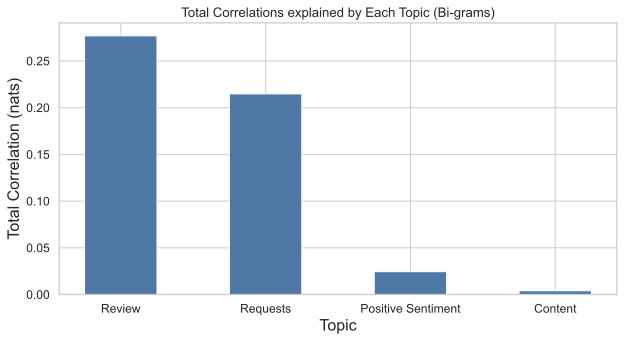

In [147]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.title('Total Correlations explained by Each Topic (Bi-grams)')
plt.xticks(np.arange(4), ['Review', 'Requests', 'Positive Sentiment', 'Content'])
plt.savefig('figures/corex_tc_topic_bi.png', bbox_inches = 'tight');
plt.savefig('figures/corex_tc_topic_bi.svg', bbox_inches = 'tight');

In [152]:
corex_2.get_top_docs(topic=1, n_docs=3)

[('Please my account viral kar do Please my ID 79.....afaqsandhujutt', 0.0),
 ('I want to grow my account', 0.0),
 ("Hello dear tiktok team. I am doing Hard Work on tiktok Videos In making and neither my video is not viral not like not comment and not follows please make my video viral, comment and many followers thank you nature Tiktok is now a very big stage. This relieves our tension. And we enjoy a lot. Thanks a lot thank you a lot of.tiktok I love tiktok I like tiktok plz viral my videos and like and make a lote of follows My Tiktok I'd is - @Ch._naveeen_Pardhan_0999 Plz viral my videos",
  0.0)]